# GMM Overextension Detector

Unsupervised Gaussian Mixture Model to flag "overextended" bar events via low log-likelihood.

- Train on first 4 days, test on 5th day.
- Features: all 9 derived features
- training data standardized
- Candidates: events with train-quantile log-likelihood below threshold (default 5th percentile).
- Outputs:
  - Model: `models/gmm.joblib`, scaler and `gmm_config.json`
  - Candidates: `data/gmm/gmm_candidates_5pct.parquet` and `data/gmm/gmm_candidates_10pct.parquet`
  - Plots: displayed inline in this notebook


In [1]:
import os, sys, json, logging
import numpy as np
import pandas as pd
import importlib
from pathlib import Path

os.chdir('..')
print(f"Working directory: {os.getcwd()}")

from src.gmm.data import load_processed, split_train_test_by_day, get_feature_matrix
from src.gmm.model import fit_scaler, tune_and_train_gmm, score_loglik, choose_threshold, save_artifacts
from src.gmm.evaluate import evaluate_gmm, make_plots

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("gmm_notebook")

pd.set_option('display.width', 160)
pd.set_option('display.max_columns', 200)


Working directory: C:\Users\doqui\OneDrive\Documents\cs4641-131-project


In [2]:
# Load processed bars

df_all = load_processed(processed_dir="data/processed", logger=logger)
print(f"Rows: {len(df_all):,}")
print(f"Days: {pd.to_datetime(df_all['date']).nunique()} | Tickers: {df_all['ticker'].nunique()}")
print("Days:", [str(d) for d in sorted(pd.to_datetime(df_all['date']).dt.date.unique())])

display(df_all.head(3))


Rows: 46,855
Days: 5 | Tickers: 20
Days: ['2025-10-02', '2025-10-03', '2025-10-06', '2025-10-07', '2025-10-08']


,ticker,date,t,t_end,open,high,low,close,volume,vwap,label,label_t_end,label_barrier_hit,trade_count,duration_seconds,ewm_std,label_holding_period_seconds,feat_vwap_zscore,feat_bollinger_position,feat_momentum_3bar,feat_momentum_5bar,feat_relative_volume,feat_time_of_day,feat_context_bar_count,feat_context_avg_volume,feat_context_price_range
0,CCL,2025-10-02,2025-10-02 13:35:03+00:00,2025-10-02 13:35:04+00:00,28.375000,28.375000,28.344999,28.370001,4631,28.353455,1,2025-10-02 13:35:24+00:00,upper,29,1.0,0.001940,20.0,0.000000,0.000000,NaN,NaN,1.000000,0.000139,0.0,4631.0,0.000000
1,CCL,2025-10-02,2025-10-02 13:35:04+00:00,2025-10-02 13:35:24+00:00,28.370001,28.420000,28.340000,28.420000,5396,28.371723,1,2025-10-02 13:35:24+00:00,upper,33,20.0,0.000251,0.0,0.000000,0.000000,NaN,NaN,1.165191,0.000185,1.0,4631.0,0.001056
2,CCL,2025-10-02,2025-10-02 13:35:24+00:00,2025-10-02 13:35:31+00:00,28.379999,28.459999,28.370001,28.459999,4628,28.437872,-1,2025-10-02 13:35:31+00:00,lower,24,7.0,0.000251,0.0,0.986192,0.919233,NaN,NaN,0.923108,0.001111,2.0,5013.5,0.002811


In [3]:
# Split into first 4 train days and 5th test day

df_train, df_test, train_days, test_day = split_train_test_by_day(df_all, logger=logger)
print("Train days:", [str(d) for d in train_days], "| Test day:", str(test_day))
print(f"Train rows: {len(df_train):,} | Test rows: {len(df_test):,}")


2025-11-04 12:13:42,169 [INFO] Train/Test split: 38193 train rows across ['2025-10-02', '2025-10-03', '2025-10-06', '2025-10-07'] | 8662 test rows on 2025-10-08


Train days: ['2025-10-02', '2025-10-03', '2025-10-06', '2025-10-07'] | Test day: 2025-10-08
Train rows: 38,193 | Test rows: 8,662


In [4]:
# Build feature matrices and scale

X_train, feature_names, idx_train = get_feature_matrix(df_train, logger=logger)
X_test, feature_names_test, idx_test = get_feature_matrix(df_test, logger=logger)
assert feature_names == feature_names_test, "Train/test feature names mismatch"

scaler, X_train_scaled = fit_scaler(X_train)
X_test_scaled = scaler.transform(X_test)

# Day groups for LODO CV (aligned to X_train rows)
train_day_groups = pd.to_datetime(df_train.loc[idx_train, 'date']).dt.date.values

print(f"X_train: {X_train_scaled.shape} | X_test: {X_test_scaled.shape}")
print(f"Features: {len(feature_names)}")


2025-11-04 12:13:43,442 [WARNING] Dropped 400 rows with NaN/Inf in features
2025-11-04 12:13:43,449 [WARNING] Dropped 100 rows with NaN/Inf in features


X_train: (37793, 9) | X_test: (8562, 9)
Features: 9


In [5]:
# Tune and fit GMM via day-level LODO CV

gmm, grid_summary = tune_and_train_gmm(
    X_train_scaled,
    day_groups=train_day_groups,
    n_components_grid=range(8, 16),
    logger=logger,
)

print("Best params:", grid_summary["best_params"])
print("Train AIC/BIC:", grid_summary["train_aic"], grid_summary["train_bic"]) 

print(pd.DataFrame(grid_summary["grid_results"]).to_string())

2025-11-04 12:13:52,071 [INFO] Tuning GMM via LODO CV on days: ['2025-10-02', '2025-10-03', '2025-10-06', '2025-10-07']
2025-11-04 12:18:13,280 [INFO] Model selection via 1-std CV rule then BIC: 8 candidates within 1 std of best CV (best CV=-7.1503, std=0.4921); selected k=12 cov=full with BIC=523135.7 and CV mean LLK=-7.2527
2025-11-04 12:18:13,281 [INFO] Best GMM params: k=12 cov=full | CV mean LLK=-7.2527 BIC=523135.7


Best params: {'n_components': 12, 'covariance_type': 'full'}
Train AIC/BIC: 517507.90639354545 523135.6867726867
    n_components covariance_type  cv_mean_loglik  cv_std_loglik      train_bic      train_aic
0             15            full       -7.150251       0.492106  530429.501446  523392.641002
1             12            full       -7.252743       0.373758  523135.686773  517507.906394
2             13            full       -7.260046       0.506833  524511.313270  518413.839536
3             11            full       -7.300259       0.492941  536847.132985  531689.045961
4             14            full       -7.309014       0.616224  524835.892231  518268.725142
5             10            full       -7.401842       0.543783  544604.928309  539916.534640
6              9            full       -7.416032       0.483241  548155.363435  543936.663121
7              8            full       -7.552806       0.574715  543466.126332  539717.119373
8             15            diag       -8

In [ ]:
# Manual override: refit with k=12
from sklearn.mixture import GaussianMixture

print("Manually overriding to k=12")
gmm_manual = GaussianMixture(
    n_components=12,
    covariance_type='full',
    random_state=42,
    max_iter=500,
    reg_covar=1e-6,
    init_params='kmeans'
)
gmm_manual.fit(X_train_scaled)

gmm = gmm_manual

grid_summary["best_params"] = {"n_components": 12, "covariance_type": "full"}
grid_summary["train_bic"] = float(gmm.bic(X_train_scaled))
grid_summary["train_aic"] = float(gmm.aic(X_train_scaled))

Manually overriding to k=12


In [ ]:
# Score train/test and choose threshold

threshold_quantile = 0.05 # default

train_llk = score_loglik(gmm, X_train_scaled)
test_llk = score_loglik(gmm, X_test_scaled)

# 5% threshold
threshold_5, thr_meta_5 = choose_threshold(train_llk, quantile=0.05)
print("5%% Threshold: %.6f" % (threshold_5,))

# 10% threshold
threshold_10, thr_meta_10 = choose_threshold(train_llk, quantile=0.10)
print("10%% Threshold: %.6f" % (threshold_10,))

threshold = threshold_5
thr_meta = thr_meta_5
print("Using 5% threshold as the primary setting for metrics and artifacts.")
thr_meta


5% Threshold: -14.181503
10% Threshold: -12.046051
Using 5% threshold as the primary setting for metrics and artifacts.


{'quantile': 0.05,
 'threshold': -14.181503264947787,
 'train_mean_loglik': -6.829173476484342,
 'train_std_loglik': 4.172118159458434}

In [8]:
# Evaluate, persist candidates, and report metrics

metrics = evaluate_gmm(
    df_train=df_train,
    df_test=df_test,
    idx_train=idx_train,
    idx_test=idx_test,
    X_train_scaled=X_train_scaled,
    X_test_scaled=X_test_scaled,
    model=gmm,
    threshold=threshold,  # 5%
    feature_names=feature_names,
    processed_outdir="data/gmm",
    logger=logger,
)

metrics


2025-11-04 12:20:39,129 [INFO] Saved GMM candidates to data\gmm\gmm_candidates.parquet (46355 rows, 5.1% flagged)


{'train_mean_loglik': -6.829173476484342,
 'test_mean_loglik': -6.857092879641654,
 'train_candidate_rate': 0.05000926097425449,
 'test_candidate_rate': 0.0533753795842093,
 'n_train': 37793,
 'n_test': 8562,
 'n_components': 12,
 'train_label_dist_flagged': {1: 963, -1: 896, 0: 31},
 'train_label_dist_unflagged': {1: 18099, -1: 17432, 0: 372},
 'test_label_dist_flagged': {1: 235, -1: 206, 0: 16},
 'test_label_dist_unflagged': {1: 4203, -1: 3819, 0: 83}}

In [10]:
# Save 5% and 10% thresholds
from pathlib import Path
import shutil

base_dir = Path("data/gmm")
base_dir.mkdir(parents=True, exist_ok=True)
base_file = base_dir / "gmm_candidates.parquet"
file_5 = base_dir / "gmm_candidates_5pct.parquet"
file_10 = base_dir / "gmm_candidates_10pct.parquet"

if base_file.exists():
    # Copy the 5% candidates file
    shutil.copyfile(base_file, file_5)

    # Create a 10% candidates file by relaxing the threshold
    df_cand = pd.read_parquet(base_file)
    if "gmm_loglik" not in df_cand.columns:
        raise ValueError("gmm_loglik not found in candidates file; cannot recompute 10% flags.")
    df_cand["gmm_is_candidate"] = df_cand["gmm_loglik"] <= threshold_10
    df_cand.to_parquet(file_10, index=False)

    print(f"Saved: {file_5}")
    print(f"Saved: {file_10}")
else:
    print("Base candidates file not found:", base_file)


Saved: data\gmm\gmm_candidates_5pct.parquet
Saved: data\gmm\gmm_candidates_10pct.parquet


In [11]:
# Save artifacts for reuse by other components

gmm_config = {
    "best_params": grid_summary["best_params"],
    "train_days": [str(d) for d in train_days],
    "test_day": str(test_day),
    "threshold": threshold,
    "threshold_quantile": threshold_quantile,
    "feature_names": feature_names,
    "metrics": metrics,
}

paths = save_artifacts(gmm, scaler, gmm_config, outdir="models", logger=logger)
paths


2025-11-04 12:21:33,907 [INFO] Saved model to models\gmm.joblib, scaler to models\gmm_scaler.joblib, config to models\gmm_config.json


{'model_path': 'models\\gmm.joblib',
 'scaler_path': 'models\\gmm_scaler.joblib',
 'config_path': 'models\\gmm_config.json'}

In [ ]:
# 5% candidates persisted for RF

cand_path = "data/gmm/gmm_candidates_5pct.parquet"
if os.path.exists(cand_path):
    cands = pd.read_parquet(cand_path)
    print("Candidates (5%):", len(cands), "Flagged share:", round(cands['gmm_is_candidate'].mean(), 4))
    display(cands.head(10))
else:
    print("Candidates file not found:", cand_path)


Candidates (5%): 46355 Flagged share: 0.0506


,ticker,date,t,t_end,gmm_loglik,gmm_is_candidate,gmm_component,label,feat_vwap_zscore,feat_bollinger_position,feat_momentum_3bar,feat_momentum_5bar,feat_relative_volume,feat_time_of_day,feat_context_bar_count,feat_context_avg_volume,feat_context_price_range
0,CCL,2025-10-02,2025-10-02 13:36:05+00:00,2025-10-02 13:36:24+00:00,-17.999703,True,2,1,0.864960,0.600875,0.001054,0.004230,0.396659,0.003009,5.0,12091.000000,0.005090
1,CCL,2025-10-02,2025-10-02 13:36:26+00:00,2025-10-02 13:37:03+00:00,-18.499216,True,2,1,-1.860753,-0.175962,-0.000703,0.000352,0.425833,0.003981,6.0,10875.166992,0.005804
2,CCL,2025-10-02,2025-10-02 13:37:03+00:00,2025-10-02 13:37:27+00:00,-17.062258,True,2,1,1.760251,0.679791,0.000527,0.001405,0.473198,0.005694,7.0,9983.142578,0.006316
3,CCL,2025-10-02,2025-10-02 13:37:27+00:00,2025-10-02 13:37:50+00:00,-18.727362,True,2,-1,1.508488,1.956025,0.004563,0.005975,0.494545,0.006806,8.0,9325.750000,0.006289
4,CCL,2025-10-02,2025-10-02 13:37:50+00:00,2025-10-02 13:38:09+00:00,-16.597496,True,2,1,-0.331997,0.831539,0.005452,0.003511,0.536696,0.007870,9.0,8802.000000,0.009795
5,CCL,2025-10-02,2025-10-02 13:38:09+00:00,2025-10-02 13:38:32+00:00,-14.317665,True,2,1,0.342229,0.793219,0.003509,0.003861,0.578495,0.008750,10.0,8394.200195,0.009790
6,CCL,2025-10-02,2025-10-02 13:38:32+00:00,2025-10-02 13:39:10+00:00,-15.912755,True,2,1,-0.113134,0.584606,-0.001223,0.005452,0.583335,0.009815,11.0,8072.545410,0.009795
7,CCL,2025-10-02,2025-10-02 13:39:10+00:00,2025-10-02 13:39:18+00:00,-13.696591,False,2,1,-0.196379,0.498818,-0.000175,0.002807,0.613558,0.011574,12.0,7792.250000,0.009797
8,CCL,2025-10-02,2025-10-02 13:39:18+00:00,2025-10-02 13:39:38+00:00,-13.616881,False,2,1,-0.215322,0.430900,-0.000874,-0.001572,0.636192,0.011944,13.0,7560.615234,0.009799
9,CCL,2025-10-02,2025-10-02 13:39:38+00:00,2025-10-02 13:39:49+00:00,-11.759192,False,2,1,-0.066380,0.499476,0.000175,0.000175,0.805932,0.012870,14.0,7364.143066,0.009794


## Final GMM parameters and quantitative metrics

The following summarizes the selected hyperparameters, threshold, and key metrics.


In [13]:
final_params = {
    "n_components": grid_summary["best_params"]["n_components"],
    "covariance_type": grid_summary["best_params"]["covariance_type"],
    "train_BIC": grid_summary["train_bic"],
    "train_AIC": grid_summary["train_aic"],
    "threshold_quantile": threshold_quantile,
    "threshold_value": threshold,
}

metrics_df = pd.DataFrame([
    {
        "split": "train",
        "mean_loglik": metrics["train_mean_loglik"],
        "candidate_rate": metrics["train_candidate_rate"],
        "n_samples": metrics["n_train"],
    },
    {
        "split": "test",
        "mean_loglik": metrics["test_mean_loglik"],
        "candidate_rate": metrics["test_candidate_rate"],
        "n_samples": metrics["n_test"],
    },
])

print("Final GMM parameters:")
display(pd.Series(final_params))

print("\nQuantitative scoring metrics:")
display(metrics_df)


Final GMM parameters:


n_components                     12
covariance_type                full
train_BIC             523135.686773
train_AIC             517507.906394
threshold_quantile             0.05
threshold_value          -14.181503
dtype: object


Quantitative scoring metrics:


,split,mean_loglik,candidate_rate,n_samples
0,train,-6.829173,0.050009,37793
1,test,-6.857093,0.053375,8562


## Visualizations


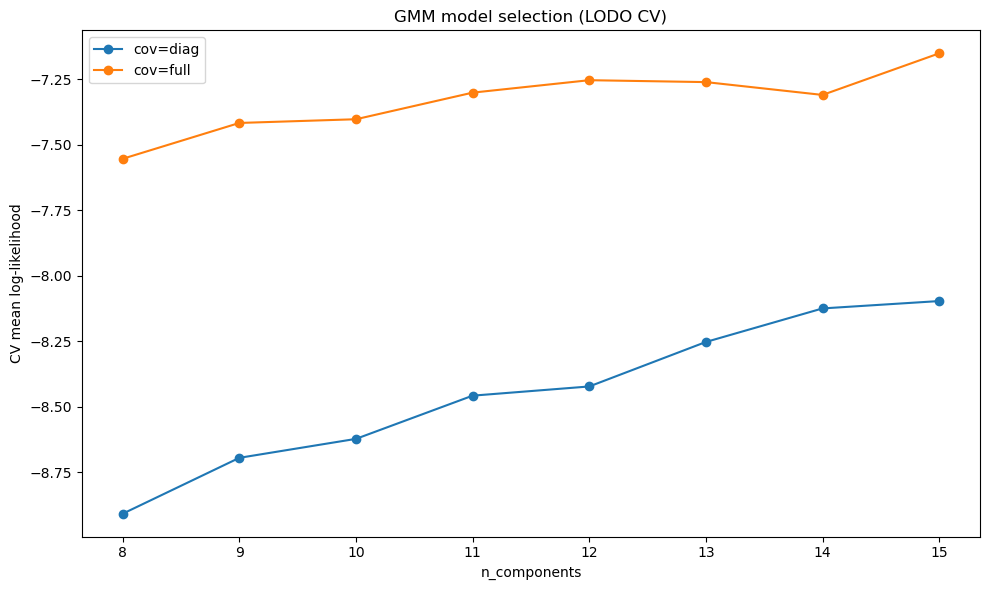

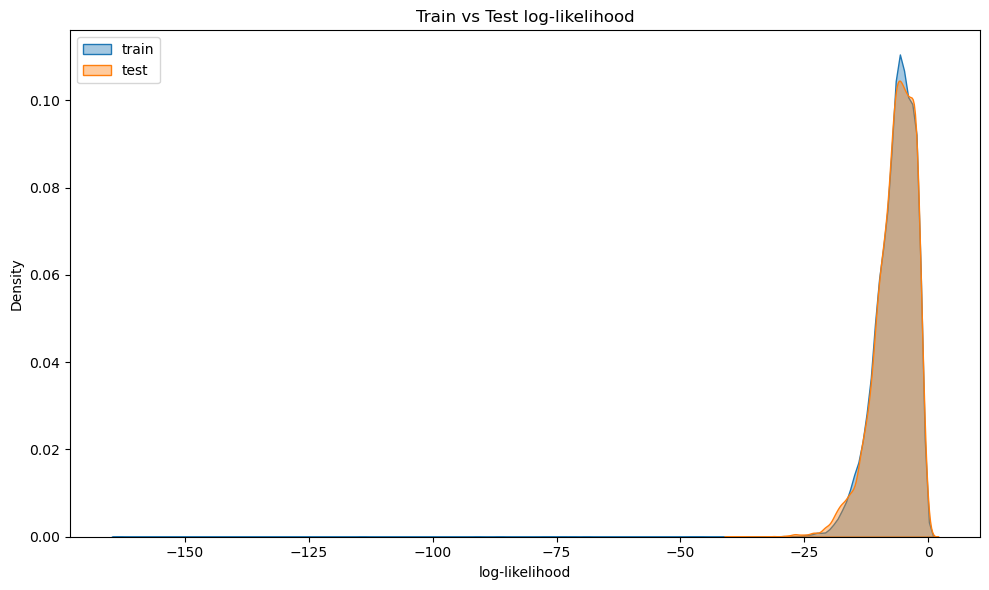

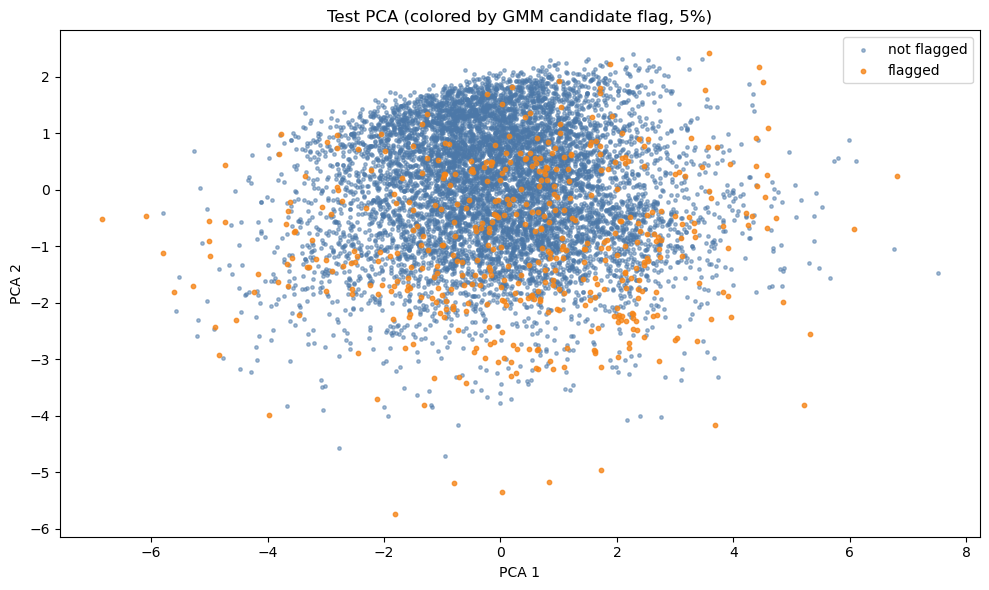

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# 1) Model selection curve (CV mean LLK vs k by cov type)
try:
    df_grid = pd.DataFrame(grid_summary.get("grid_results", []))
    if not df_grid.empty:
        plt.figure(figsize=(10, 6))
        for cov, sub in df_grid.groupby("covariance_type"):
            sub_sorted = sub.sort_values("n_components")
            plt.plot(sub_sorted["n_components"], sub_sorted["cv_mean_loglik"], marker="o", label=f"cov={cov}")
        plt.xlabel("n_components")
        plt.ylabel("CV mean log-likelihood")
        plt.title("GMM model selection (LODO CV)")
        plt.legend()
        plt.tight_layout()
        plt.show()
except Exception as exc:
    print("Failed to plot model selection:", exc)

# 2) Log-likelihood distributions (train vs test)
try:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train_llk, fill=True, alpha=0.4, label="train")
    sns.kdeplot(test_llk, fill=True, alpha=0.4, label="test")
    plt.xlabel("log-likelihood")
    plt.title("Train vs Test log-likelihood")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as exc:
    print("Failed to plot LLK distributions:", exc)

# 3) PCA scatter of test colored by 5% flag
try:
    test_flags_5 = (test_llk <= threshold)
    pca = PCA(n_components=2, random_state=42)
    Z = pca.fit_transform(X_test_scaled)
    plt.figure(figsize=(10, 6))
    plt.scatter(Z[~test_flags_5, 0], Z[~test_flags_5, 1], s=6, c="#4c78a8", alpha=0.5, label="not flagged")
    plt.scatter(Z[test_flags_5, 0], Z[test_flags_5, 1], s=10, c="#f58518", alpha=0.8, label="flagged")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title("Test PCA (colored by GMM candidate flag, 5%)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as exc:
    print("Failed to plot PCA scatter:", exc)

fig_paths = None


2025-11-04 12:22:15,902 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-04 12:22:15,911 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


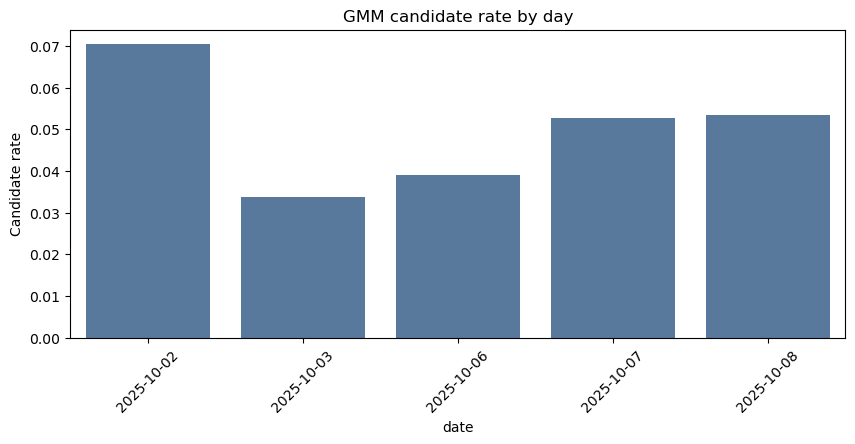

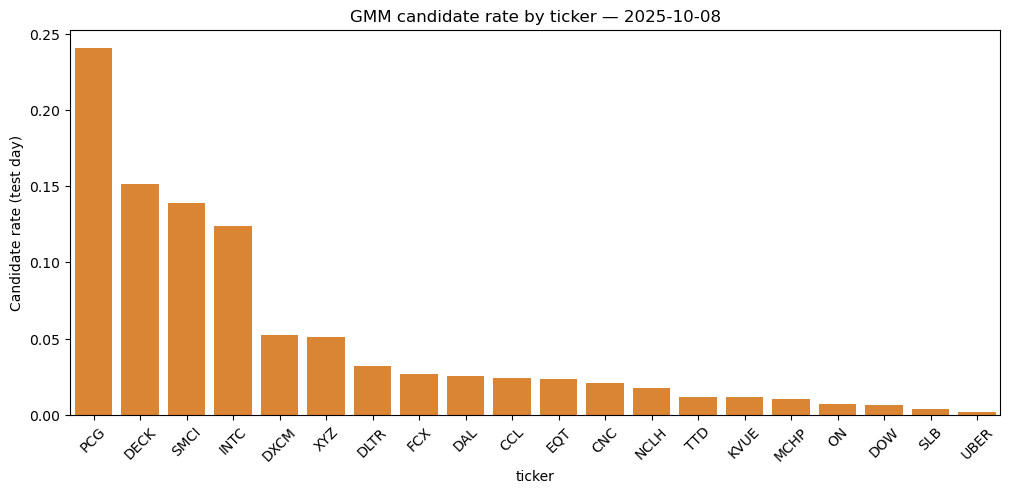

2025-11-04 12:22:16,561 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-04 12:22:16,604 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


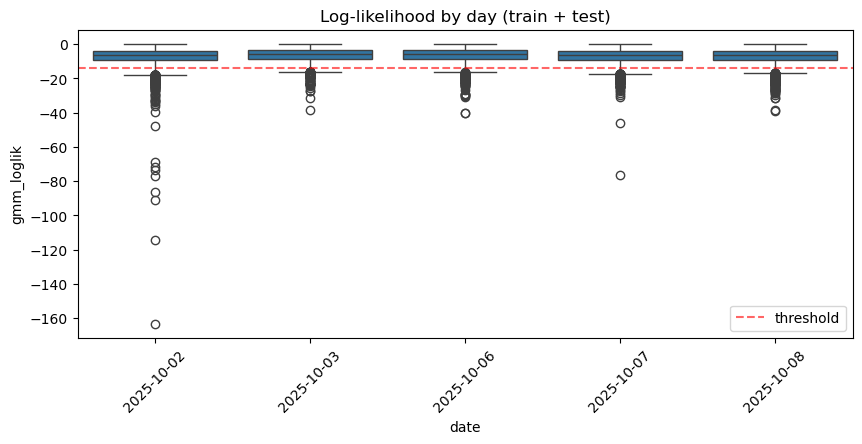

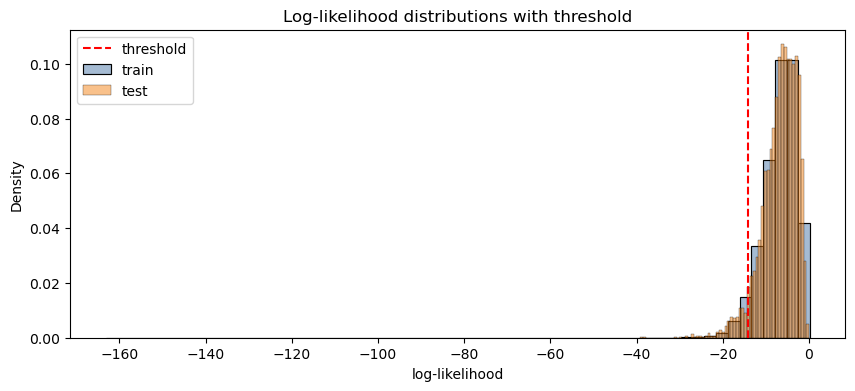

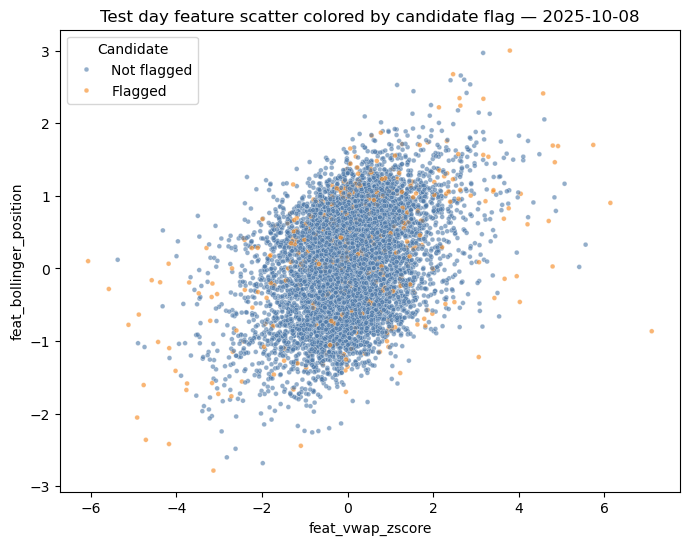

2025-11-04 12:22:17,904 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-04 12:22:17,908 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


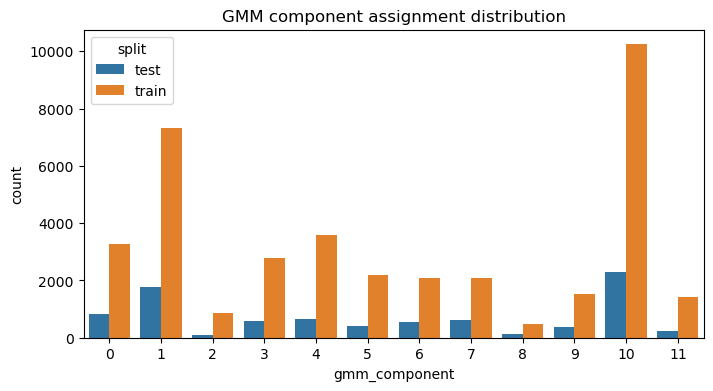

In [ ]:
cand_path = "data/gmm/gmm_candidates_5pct.parquet"
if not os.path.exists(cand_path):
    print("Candidates file not found:", cand_path)
else:
    cands = pd.read_parquet(cand_path)
    cands["date"] = pd.to_datetime(cands["date"])

    # Candidate rate by day (train days vs test day)
    by_day = cands.groupby("date")["gmm_is_candidate"].mean().reset_index()
    plt.figure(figsize=(10, 4))
    sns.barplot(data=by_day, x="date", y="gmm_is_candidate", color="#4c78a8")
    plt.ylabel("Candidate rate")
    plt.title("GMM candidate rate by day")
    plt.xticks(rotation=45)
    plt.show()

    # For the held-out test day, candidate rate by ticker
    test_day_ts = pd.to_datetime(test_day)
    day_mask = cands["date"].dt.normalize() == test_day_ts.normalize()
    c_test = cands.loc[day_mask].copy()
    by_ticker = c_test.groupby("ticker")["gmm_is_candidate"].mean().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(12, 5))
    sns.barplot(data=by_ticker, x="ticker", y="gmm_is_candidate", color="#f58518")
    plt.ylabel("Candidate rate (test day)")
    plt.title(f"GMM candidate rate by ticker — {test_day_ts.date()}")
    plt.xticks(rotation=45)
    plt.show()

    # Log-likelihood boxplot by day
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=cands, x="date", y="gmm_loglik")
    plt.axhline(threshold, color="red", linestyle="--", alpha=0.6, label="threshold")
    plt.title("Log-likelihood by day (train + test)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

    # LLK histogram for train/test with threshold line
    plt.figure(figsize=(10, 4))
    sns.histplot(train_llk, bins=60, color="#4c78a8", alpha=0.5, stat="density", label="train")
    sns.histplot(test_llk, bins=60, color="#f58518", alpha=0.5, stat="density", label="test")
    plt.axvline(threshold, color="red", linestyle="--", label="threshold")
    plt.xlabel("log-likelihood")
    plt.title("Log-likelihood distributions with threshold")
    plt.legend()
    plt.show()

    
    cands["flag_label"] = np.where(cands["gmm_is_candidate"], "Flagged", "Not flagged")
    c_test["flag_label"] = np.where(c_test["gmm_is_candidate"], "Flagged", "Not flagged")

    # 2D feature scatter (if common features present) colored by flags on test day
    feat_x = "feat_vwap_zscore"
    feat_y = "feat_bollinger_position"
    if feat_x in c_test.columns and feat_y in c_test.columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=c_test, x=feat_x, y=feat_y,
            hue="flag_label", palette={"Not flagged": "#4c78a8", "Flagged": "#f58518"},
            alpha=0.6, s=12
        )
        plt.title(f"Test day feature scatter colored by candidate flag — {test_day_ts.date()}")
        plt.legend(title="Candidate")
        plt.show()
    else:
        missing = [f for f in [feat_x, feat_y] if f not in c_test.columns]
        print("Skipping feature scatter; missing:", missing)

    # Component assignment distribution by split (train vs test day)
    cands["split"] = np.where(cands["date"].dt.normalize() == test_day_ts.normalize(), "test", "train")
    comp_dist = cands.groupby(["split", "gmm_component"]).size().reset_index(name="count")
    plt.figure(figsize=(8, 4))
    sns.barplot(data=comp_dist, x="gmm_component", y="count", hue="split")
    plt.title("GMM component assignment distribution")
    plt.show()


### Label diagnostics

Compare label distribution among flagged vs unflagged for the test day.


In [17]:
cand_path = "data/gmm/gmm_candidates_5pct.parquet"
if os.path.exists(cand_path):
    cands = pd.read_parquet(cand_path)
    cands["date"] = pd.to_datetime(cands["date"])  # datetime64[ns]
    test_day_ts = pd.to_datetime(test_day)
    c_test = cands[cands["date"].dt.normalize() == test_day_ts.normalize()].copy()
    if "label" in c_test.columns:
        print("Label distribution in flagged vs unflagged (test day):")
        c_test["flag_label"] = np.where(c_test["gmm_is_candidate"], "Flagged", "Not flagged")
        ct = pd.crosstab(c_test["label"], c_test["flag_label"], normalize="columns")
        display(ct)
    else:
        print("No 'label' column found for label diagnostics.")
else:
    print("Candidates file not found for label diagnostics.")


Label distribution in flagged vs unflagged (test day):


flag_label,Flagged,Not flagged
label,,
-1,0.450766,0.471191
0,0.035011,0.010241
1,0.514223,0.518569
